In [1]:
using PyCall
# push local path to python path
pushfirst!(PyVector(pyimport("sys")["path"]), "")
#lkTable=pyimport("lkTables")
py_util=pyimport("python_util")

PyObject <module 'python_util' from '/Users/mgrecu/NewFrameworks/eddgn_jacobian/python_util.py'>

In [2]:
#println(py_util.lookupT.dmr)
fname="/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20190502-S100527-E101407.029398.V07A.HDF5"
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat=py_util.readCMB(fname);
fname_GMI="/Users/mgrecu/GPM/ORO_old/2A-CS/1C-R-CS-CONUS.GPM.GMI.XCAL2016-C.20190502-S100409-E101413.029398.V07A.HDF5"
gmi_lat, gmi_lon, gmi_tc=py_util.readGMI(fname_GMI)
gmi_tc_resampled=py_util.resample_gmi(gmi_lat, gmi_lon, gmi_tc, lon, lat);

/Users/mgrecu/miniforge3/lib/python3.10/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


In [3]:
nt=size(zCorrected)[1]
#kext_gases=np.zeros((nt,49,78,8))
#temp_layer=np.zeros((nt,49,79))
np=pyimport("numpy")
freqs=[10.65,18.7,23.8,37.0,89.0,166,183.3+3,183.3+7]
hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
gFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,8]
kext_atm=np.zeros((nt,49,79,8))
temp_layer=np.zeros((nt,49,79),dtype=np.float32)
for i in 1:nt
    for j in 1:49
        n5=envNodes[i,j,:]
        press1d=np.interp(10:88,n5,press[i,j,:])
        qv1d=np.interp(10:88,n5,qv[i,j,:])
        temp1d=np.interp(10:88,n5,airTemp[i,j,:])
        temp_layer1d=np.interp(np.arange(9.5,88.5,1),n5,airTemp[i,j,:])
        qv1d[qv1d.<1e-3].=1e-3
        rho1d=press1d./(287.05*temp1d)*1e2
        ireturn=0
        rhowv1d=rho1d.*qv1d.*1e-3
        press1d_pa=press1d.*1e2
        kext = py_util.rt.get_wv_extinction(freqs,temp1d,rhowv1d,press1d_pa)
        kext_atm[i,j,:,:]=kext';
        temp_layer[i,j,:]=temp1d;
    end
end
      

In [5]:
using PyPlot
plt=pyimport("matplotlib.pyplot")

PyObject <module 'matplotlib.pyplot' from '/Users/mgrecu/miniforge3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [6]:

# Assuming nt, a, pwc, binNodes, dm, pType, lookupT, sfcBin are defined and initialized

kext3d = zeros(Float64, nt, 49, 88, 7)
salb3d = zeros(Float64, nt, 49, 88, 7)
asym3d = zeros(Float64, nt, 49, 88, 7)
iwp = zeros(Float64, nt, 49)
rwp = zeros(Float64, nt, 49)

function bisectm(xvec, r)
    n = length(xvec)
    if r <= xvec[1]
        return 1
    elseif r >= xvec[n]
        return n
    end
    
    low, high = 1, n
    while low <= high
        mid = div(low + high, 2)
        if xvec[mid] == r
            return mid
        elseif xvec[mid] < r
            low = mid + 1
        else
            high = mid - 1
        end
    end
    
    if abs(xvec[low] - r) < abs(xvec[high] - r)
        return low
    else
        return high
    end
end
println(nt)


743


In [7]:
lookupT=py_util.lookupT
kext3d = zeros(Float64, nt, 49, 88, 7)
salb3d = zeros(Float64, nt, 49, 88, 7)
asym3d = zeros(Float64, nt, 49, 88, 7)
for i in 1:nt
    for j in 1:49
        kext_rain=zeros(Float64,7)
        salb_rain=zeros(Float64,7)
        asym_rain=zeros(Float64,7)
        pwc1 = pwc[i, j, :]
        a0 = findall(pwc1.>0)
        for k in a0
            dm1 = dm[i, j, k]
            if k <= binNodes[i, j, 4]
                iphase = 0
                if pType[i, j] != 2
                    ind = bisectm(lookupT.dms, dm1)
                    dns = log10(pwc[i, j, k] / lookupT.swc[ind])
                    kext_snow = lookupT.kextS[ind, :] .* 10^dns
                    salb_snow = lookupT.salbS[ind, :]
                    asym_snow = lookupT.asymS[ind, :]
                else
                    ind = bisectm(lookupT.dmg.data, dm1)
                    dng = log10(pwc[i, j, k] / lookupT.gwc[ind])
                    kext_snow = lookupT.kextG[ind, :] .* 10^dng
                    salb_snow = lookupT.salbG[ind, :]
                    asym_snow = lookupT.asymG[ind, :]
                end
            end

            if k > binNodes[i, j, 3]
                ind = bisectm(lookupT.dmr, dm1)
                dnr = log10(pwc[i, j, k] / lookupT.rwc[ind])
                kext_rain = lookupT.kextR[ind, :] .* 10^dnr
                salb_rain = lookupT.salbR[ind, :]
                asym_rain = lookupT.asymR[ind, :]
            end
        
            if k <= binNodes[i, j, 3]
                kext = kext_snow
                salb = salb_snow
                asym = asym_snow
            else
                if k < binNodes[i, j, 4]
                    f = (k - binNodes[i, j, 3]) / (binNodes[i, j, 4] - binNodes[i, j, 3])
                    kext = kext_snow .* (1 - f) + kext_rain .* f
                    salb = (salb_snow .* (1 - f) .* kext_snow + salb_rain .* f .* kext_rain)
                    asym = (asym_snow .* (1 - f) .* kext_snow .* asym_snow + asym_rain .* f .* kext_rain .* asym_rain) ./ salb
                    salb = salb ./ kext
                else
                    kext = kext_rain
                    salb = salb_rain
                    asym = asym_rain
                end
            end     
            kext3d[i, j, k, :] = kext
            salb3d[i, j, k, :] = salb
            asym3d[i, j, k, :] = asym
        
            if k == a0[end] && k>=binNodes[i, j, 5]
               for k1 in k+1:88
                    kext3d[i, j, k1, :] = kext_rain
                    salb3d[i, j, k1, :] = salb_rain
                    asym3d[i, j, k1, :] = asym_rain
                end
            end
        end
    end
end


In [8]:
function scatteringProperties(pwc, dm, binNodes, pType, lookupT, sfcBin)
    kext3d = zeros(Float64, nt, 49, 88, 7)
    salb3d = zeros(Float64, nt, 49, 88, 7)
    asym3d = zeros(Float64, nt, 49, 88, 7)
    for i in 1:nt
        for j in 1:49
            kext_rain=zeros(Float64,7)
            salb_rain=zeros(Float64,7)
            asym_rain=zeros(Float64,7)
            pwc1 = pwc[i, j, :]
            a0 = findall(pwc1.>0)
            for k in a0
                dm1 = dm[i, j, k]
                if k <= binNodes[i, j, 4]
                    iphase = 0
                    if pType[i, j] != 2
                        ind = bisectm(lookupT.dms, dm1)
                        dns = log10(pwc[i, j, k] / lookupT.swc[ind])
                        kext_snow = lookupT.kextS[ind, :] .* 10^dns
                        salb_snow = lookupT.salbS[ind, :]
                        asym_snow = lookupT.asymS[ind, :]
                    else
                        ind = bisectm(lookupT.dmg.data, dm1)
                        dng = log10(pwc[i, j, k] / lookupT.gwc[ind])
                        kext_snow = lookupT.kextG[ind, :] .* 10^dng
                        salb_snow = lookupT.salbG[ind, :]
                        asym_snow = lookupT.asymG[ind, :]
                    end
                end

                if k > binNodes[i, j, 3]
                    ind = bisectm(lookupT.dmr, dm1)
                    dnr = log10(pwc[i, j, k] / lookupT.rwc[ind])
                    kext_rain = lookupT.kextR[ind, :] .* 10^dnr
                    salb_rain = lookupT.salbR[ind, :]
                    asym_rain = lookupT.asymR[ind, :]
                end
        
                if k <= binNodes[i, j, 3]
                    kext = kext_snow
                    salb = salb_snow
                    asym = asym_snow
                else
                    if k < binNodes[i, j, 4]
                        f = (k - binNodes[i, j, 3]) / (binNodes[i, j, 4] - binNodes[i, j, 3])
                        kext = kext_snow .* (1 - f) + kext_rain .* f
                        salb = (salb_snow .* (1 - f) .* kext_snow + salb_rain .* f .* kext_rain)
                        asym = (asym_snow .* (1 - f) .* kext_snow .* asym_snow + asym_rain .* f .* kext_rain .* asym_rain) ./ salb
                        salb = salb ./ kext
                    else
                        kext = kext_rain
                        salb = salb_rain
                        asym = asym_rain
                    end
                end
        
                kext3d[i, j, k, :] = kext
                salb3d[i, j, k, :] = salb
                asym3d[i, j, k, :] = asym
        
                if k == a0[end] && k>=binNodes[i, j, 5]
                    for k1 in k+1:88
                        kext3d[i, j, k1, :] = kext_rain
                        salb3d[i, j, k1, :] = salb_rain
                        asym3d[i, j, k1, :] = asym_rain
                    end
                end
            end
        end
    end
    return kext3d, salb3d, asym3d
end
kext3d_t,salb3d_t,asym3d_t=scatteringProperties(pwc, dm, binNodes, pType, lookupT, sfcBin);


In [9]:

apwc=findall(pwc.>0);
dpwc=similar(pwc);
dpwc.=0;
dpwc[apwc].=0.05;

kext3d_p, salb3d_p, asym3d_p = scatteringProperties(pwc.+dpwc, dm, binNodes, pType, lookupT, sfcBin);

In [10]:
kext_tot=kext_atm[:,:,:,1:7].+kext3d[:,:,10:end,:];
fract=kext3d[:,:,10:end,:]./kext_tot;
salb3d_tot=salb3d[:,:,10:end,:].*fract;
asym3d_tot=asym3d[:,:,10:end,:];
kext_tot1=kext_atm[:,:,:,1:7].+kext3d_p[:,:,10:end,:];
fract1=kext3d_p[:,:,10:end,:]./kext_tot1;
salb3d_tot1=salb3d_p[:,:,10:end,:].*fract1;
asym3d_tot1=asym3d_p[:,:,10:end,:];


In [11]:
include("eddington.jl")
using Enzyme
function tbwrapper(temp1, kext1, salb1, asym1, n, emiss, dz, incAng)
    ts=(temp1[1])
    A,B=SetEddington1D(temp1, kext1, salb1, asym1, n, emiss, dz, ts );
    I01p=A\B;
    Tb_jl=tbf90(I01p, temp1, incAng, kext1, salb1, asym1, n, emiss, dz);
    return Tb_jl
end
function tbwrapper_enz(params,tb_out)
    n=Int((size(params)[1]-3)/4)
    n1=n
    kext1=(params[1:n1])
    salb1=(params[n1+1:2*n1])
    asym1=(params[2*n1+1:3*n1])
    temp1=(params[3*n1+1:4*n1])
    eps=params[4*n1+1]
    dz=params[4*n1+2]
    incAng=params[4*n1+3]
    n1=n-1
    tb_jl=tbwrapper(temp1, kext1, salb1, asym1, n1, eps, dz, incAng)
    tb_out[1]=tb_jl
    return nothing
end
function params2scattering(adjparams)
    n=Int((size(adjparams)[1]-3)/4)
    n1=n
    #print(n," ")
    kext1=(adjparams[1:n1])
    salb1=(adjparams[n1+1:2*n1])
    asym1=(adjparams[2*n1+1:3*n1])
    temp1=(adjparams[3*n1+1:4*n1])
    eps=adjparams[4*n1+1]
    dz=adjparams[4*n1+2]
    incAng=adjparams[4*n1+3]
    return kext1, salb1, asym1, temp1, eps, dz, incAng
end
#A,B=SetEddington1D(temp1, kext1, salb1, asym1, n, emiss, dz, temp1[1]);
#println(size(A), " ", size(B))
#I01p=A\B;
#Tb_jl=tbf90(I01p, temp1, incAng, kext1, salb1, asym1, n, emiss, dz);
#n=78;
emiss=0.7;
dz=0.25;
TbL=[]
incAng=53.0;
nt=size(kext_tot)[1]
tb2d=zeros(Float64,nt,49,8)
tb2d_enz=zeros(Float64,nt,49,8)
adjpwc=zeros(Float64,nt,49,79,7)
@time for i in 500:550
    for j in 1:49
        for ifreq in 1:7
            kext1=Float64.(kext_tot[i,j,end:-1:1,ifreq]);
            salb1=Float64.(salb3d_tot[i,j,end:-1:1,ifreq]);
            asym1=Float64.(asym3d_tot[i,j,end:-1:1,ifreq]);
            temp1=Float64.(temp_layer[i,j,end:-1:1]);
            n=78;
            #Tb_jl=tbwrapper(temp1, kext1, salb1, asym1, n, emiss, dz, incAng);
            params=Float64.(vcat(kext1, salb1, asym1, temp1, emiss, dz, incAng));
            n1=Int((size(params)[1]-3)/4)
            tbj=[0.0];
            adjtb=[1.0];
            adjparams=zeros(eltype(params),size(params)[1])
            tbwrapper_enz(params,tbj)
            Enzyme.autodiff(Reverse,tbwrapper_enz, Duplicated(params,adjparams), Duplicated(tbj, adjtb))
            adjkext,adjsalb,adjasym,adjtemp,adeps,adjdz,adjincAng=params2scattering(adjparams)
            #tb2d[i,j,ifreq]=Tb_jl;
            tb2d_enz[i,j,ifreq]=tbj[1];
            dkext=kext_tot1[i,j,end:-1:1,ifreq]-kext_tot[i,j,end:-1:1,ifreq];
            dsalb=salb3d_tot1[i,j,end:-1:1,ifreq]-salb3d_tot[i,j,end:-1:1,ifreq];
            dasym=asym3d_tot1[i,j,end:-1:1,ifreq]-asym3d_tot[i,j,end:-1:1,ifreq];
            adjpwc[i,j,:,ifreq]=adjkext.*dkext.+adjsalb.*dsalb.+adjasym.*dasym;
            #println(Tb_jl, " ", tbj[1])
        end
    end
end

 32.659052 seconds (36.96 M allocations: 26.026 GiB, 4.88% gc time, 34.87% compilation time)


(16, 79, 7)(16, 88)
(16, 79, 7)


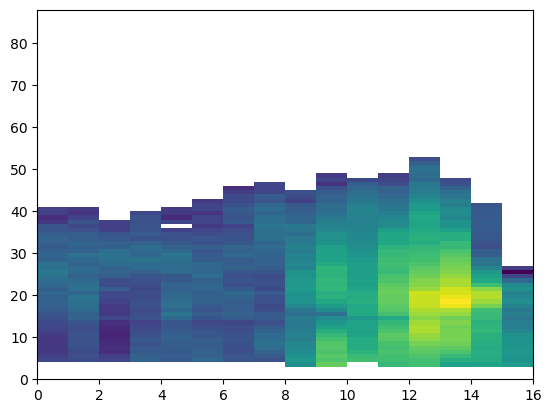

PyObject <matplotlib.collections.QuadMesh object at 0x33fa59b40>

In [12]:
print(size(adjpwc[530:545,25,:,:]))
println(size(pwc[530:545,25,:]));
println(size(kext_tot[530:545,25,:,:]));
plt.pcolormesh(pwc[530:545,25,end:-1:1]',norm=PyPlot.matplotlib.colors.LogNorm())

In [14]:
xr=pyimport("xarray")

adjpwc_xr=xr.DataArray(adjpwc[530:545,25,:,:]/0.05,dims=("scan","height","freq"),coords=Dict("scan"=>1:16,"height"=>(1:79).*0.25,"freq"=>freqs[1:7]))
pwc_xr=xr.DataArray(pwc[530:545,25,end:-1:10]/0.05,dims=("scan","height"),coords=Dict("scan"=>1:16,"height"=>(1:79).*0.25))
kexttot_xr=xr.DataArray(kext_tot[530:545,25,:,:],dims=("scan","height","freq"),coords=Dict("scan"=>1:16,"height"=>(1:79).*0.25,"freq"=>freqs[1:7]))
ds=xr.Dataset(Dict("dTb_over_dpwc"=>adjpwc_xr,"pwc"=>pwc_xr,"kext"=>kexttot_xr))
ds.to_netcdf("dTb_over_dpwc.nc")

0.6352030214695379
0.0
(743, 49, 79, 7)

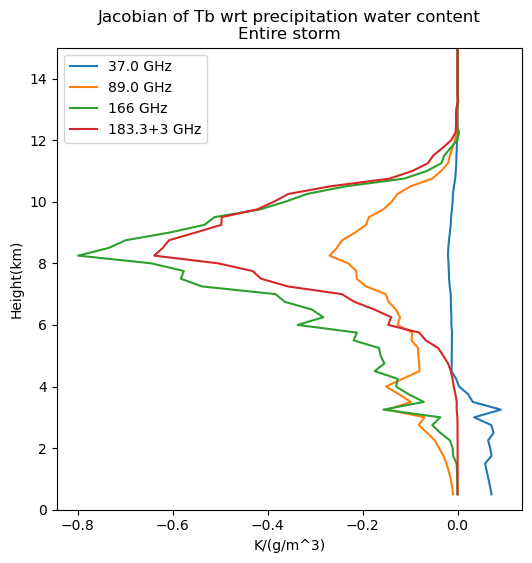

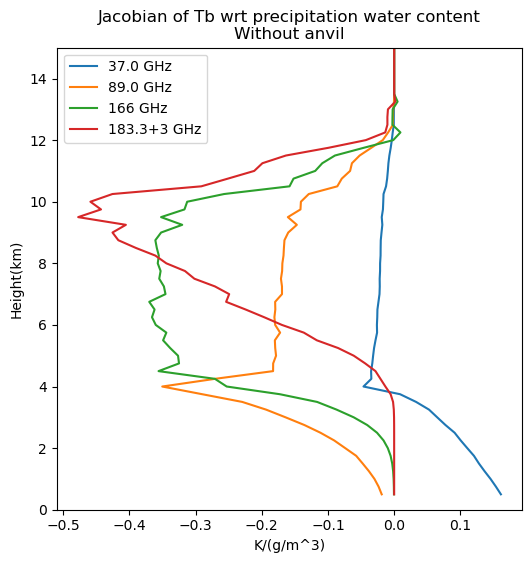

In [133]:
println(maximum(adjpwc[500:550,25,:,5]))
println(minimum(tb2d[500:550,25,:]))
#using Statistics
jacobian_pwc=[]
plt.figure(figsize=(6,6))
for i in 4:7
    dTbdpwc1=mean(adjpwc[500:550,25,2:end,i],dims=1)
    push!(jacobian_pwc/0.05,dTbdpwc1)
    plot(dTbdpwc1[:]',(2:79).*0.25)
end
plt.ylim(0,15)
plt.legend(["37.0","89.0","166","183.3+3"])
plt.legend(["37.0 GHz","89.0 GHz","166 GHz","183.3+3 GHz"])
plt.ylabel("Height(km)")
plt.xlabel("K/(g/m^3)")
plt.title("Jacobian of Tb wrt precipitation water content\nEntire storm")
plt.savefig("jacobian_pwc_with_anvil.png")

plt.figure(figsize=(6,6))
for i in 4:7
    dTbdpwc1=mean(adjpwc[530:545,25,2:end,i],dims=1)
    push!(jacobian_pwc/0.05,dTbdpwc1)
    plot(dTbdpwc1[:]',(2:79).*0.25)
end
plt.ylim(0,15)
plt.legend(["37.0 GHz","89.0 GHz","166 GHz","183.3+3 GHz"])
plt.ylabel("Height(km)")
plt.xlabel("K/(g/m^3)")
plt.title("Jacobian of Tb wrt precipitation water content\nWithout anvil")
plt.savefig("jacobian_pwc_without_anvil.png")
#z2=mean(adjpwc[:,25,:],dims=1)
print(size(adjpwc))
#plot(z2[:,5]',(1:79).*0.25)

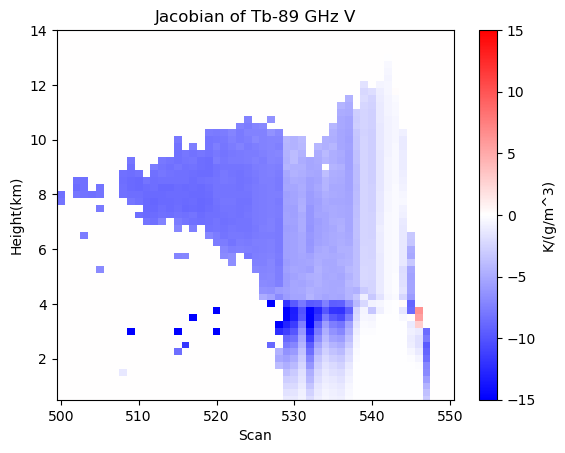

In [167]:

plt.pcolormesh(500:550,(0:78)*0.25,((adjpwc[500:550,25,:,5])./0.05)',cmap="bwr",vmin=-15.0,vmax=15.0)
plt.ylim(0.5,14)
plt.xlabel("Scan")
plt.ylabel("Height(km)")
plt.title("Jacobian of Tb-89 GHz V")
plt.colorbar(label="K/(g/m^3)")
plt.savefig("jacobian_tb89_pwc.png")


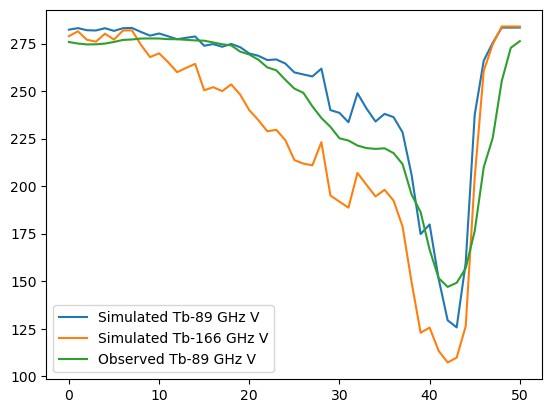

PyObject <matplotlib.legend.Legend object at 0x1657d9db0>

In [43]:
plt.plot(tb2d[500:550,25,5],label="Simulated Tb-89 GHz V")
plt.plot(tb2d[500:550,25,6],label="Simulated Tb-166 GHz V")
plt.plot(gmi_tc_resampled[500:550,25,8],label="Observed Tb-89 GHz V")
plt.legend()

In [ ]:

find_closest(py_util.lookupT.dmr,1.5)
print(py_util.lookupT.dmr[198])

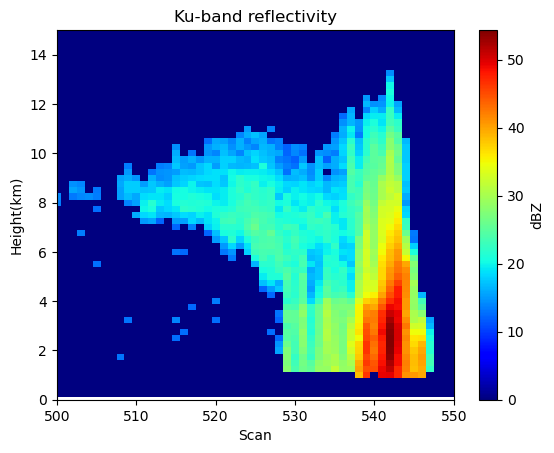

In [127]:
using PyPlot
mplt=pyimport("matplotlib.pyplot")
mcolors=pyimport("matplotlib.colors")
#plt=pyimport("matplotlib.pyplot")
#plt.subplot(211)
#plt.pcolormesh(kext3d[:,25,end:-1:1,4]',norm=mcolors.LogNorm(vmin=1e-5,vmax=1e-1),cmap="jet")
xlim(500,550)
#plt.subplot(212)
zCorrectedm=np.ma.array(zCorrected,mask=zCorrected.<10)
plt.pcolormesh(1:nt,(1:88).*0.25,zCorrectedm[:,25,end:-1:1,1]',vmin=0,cmap="jet")
xlim(500,550)
plt.xlabel("Scan")
plt.ylabel("Height(km)")
plt.title("Ku-band reflectivity")
plt.ylim(0,15)
plt.colorbar(label="dBZ")
plt.savefig("ku_reflectivity.png")
#ylim(0,45)